<a href="https://colab.research.google.com/github/Parikshit5588/deep/blob/master/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%%writefile transmtdp.py
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import argparse
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
from tqdm import tqdm
from scipy.ndimage import sobel


#########################
# MODEL IMPLEMENTATION
#########################

class TransEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(TransEncoder, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: [batch_size, seq_len, embed_dim]
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, embed_dim]

        # Self-attention block
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Feed forward block
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.norm2(x)

        return x.permute(1, 0, 2)  # [batch_size, seq_len, embed_dim]


class TransDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(TransDecoder, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: [batch_size, seq_len, embed_dim]
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, embed_dim]

        # Self-attention block
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Feed forward block
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.norm2(x)

        return x.permute(1, 0, 2)  # [batch_size, seq_len, embed_dim]


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSample, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        before_pool = self.conv_block(x)
        x = self.pool(before_pool)
        return x, before_pool


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)

        # Handle the case where dimensions don't match exactly
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([skip, x], dim=1)
        x = self.conv_block(x)
        return x


class TransMTDP(nn.Module):
    def __init__(self, input_channels, num_classes=1, num_isodose_classes=7, embed_dim=256, num_heads=8):
        super(TransMTDP, self).__init__()

        # Shared Encoder - CNN part
        self.down1 = DownSample(input_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)

        # Position Encoding
        self.register_buffer("position_encoding", torch.zeros(1, 128*128, embed_dim))
        self.position_encoding.requires_grad = True

        # Transformer Encoder
        self.transformer_encoder = TransEncoder(embed_dim, num_heads)

        # Task-specific Transformer Decoders
        self.dose_transformer_decoder = TransDecoder(embed_dim, num_heads)
        self.isodose_transformer_decoder = TransDecoder(embed_dim, num_heads)
        self.gradient_transformer_decoder = TransDecoder(embed_dim, num_heads)

        # Dose Prediction Decoder
        self.up1_dose = UpSample(256, 128)
        self.up2_dose = UpSample(128, 64)
        self.up3_dose = UpSample(64, 32)
        self.out_dose = nn.Conv2d(32, num_classes, kernel_size=1)
        self.sigmoid_dose = nn.Sigmoid()

        # Isodose Lines Prediction Decoder
        self.up1_isodose = UpSample(256, 128)
        self.up2_isodose = UpSample(128, 64)
        self.up3_isodose = UpSample(64, 32)
        self.out_isodose = nn.Conv2d(32, num_isodose_classes, kernel_size=1)

        # Gradient Prediction Decoder
        self.up1_gradient = UpSample(256, 128)
        self.up2_gradient = UpSample(128, 64)
        self.up3_gradient = UpSample(64, 32)
        self.out_gradient = nn.Conv2d(32, num_classes, kernel_size=1)
        self.sigmoid_gradient = nn.Sigmoid()

        # Initialize position encoding
        self._init_position_encoding()

    def _init_position_encoding(self):
        # Initialize position encoding
        position = torch.zeros(1, 128*128, self.position_encoding.size(2))
        for i in range(128):
            for j in range(128):
                position[0, i*128 + j, :] = self._get_position_angle_vector(i*128 + j, self.position_encoding.size(2))
        self.position_encoding.copy_(position)

    def _get_position_angle_vector(self, position, d_model):
        # Initialize position encoding based on sinusoidal functions
        return torch.tensor([position / np.power(10000, 2 * (i // 2) / d_model) for i in range(d_model)])

    def forward(self, x):
        # Shared encoder
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)

        # Flatten and add position encoding
        batch_size, C, H, W = x.shape
        x_flat = x.flatten(2).transpose(1, 2)  # [B, H*W, C]

        # Use position encoding of appropriate size
        pos_enc = self.position_encoding[:, :H*W, :]
        x_flat = x_flat + pos_enc

        # Pass through transformer encoder
        x_trans = self.transformer_encoder(x_flat)

        # Task-specific transformer decoders
        x_dose = self.dose_transformer_decoder(x_trans)
        x_isodose = self.isodose_transformer_decoder(x_trans)
        x_gradient = self.gradient_transformer_decoder(x_trans)

        # Reshape back to spatial format
        x_dose = x_dose.transpose(1, 2).reshape(batch_size, -1, H, W)
        x_isodose = x_isodose.transpose(1, 2).reshape(batch_size, -1, H, W)
        x_gradient = x_gradient.transpose(1, 2).reshape(batch_size, -1, H, W)

        # Dose prediction decoder
        x_dose = self.up1_dose(x_dose, skip3)
        x_dose = self.up2_dose(x_dose, skip2)
        x_dose = self.up3_dose(x_dose, skip1)
        dose_pred = self.sigmoid_dose(self.out_dose(x_dose))

        # Isodose lines prediction decoder
        x_isodose = self.up1_isodose(x_isodose, skip3)
        x_isodose = self.up2_isodose(x_isodose, skip2)
        x_isodose = self.up3_isodose(x_isodose, skip1)
        isodose_pred = self.out_isodose(x_isodose)

        # Gradient prediction decoder
        x_gradient = self.up1_gradient(x_gradient, skip3)
        x_gradient = self.up2_gradient(x_gradient, skip2)
        x_gradient = self.up3_gradient(x_gradient, skip1)
        gradient_pred = self.sigmoid_gradient(self.out_gradient(x_gradient))

        return dose_pred, isodose_pred, gradient_pred


# Define the loss functions as described in the paper
class DoseLoss(nn.Module):
    def __init__(self):
        super(DoseLoss, self).__init__()

    def forward(self, pred, target):
        return F.l1_loss(pred, target)


class IsodoseLoss(nn.Module):
    def __init__(self):
        super(IsodoseLoss, self).__init__()

    def forward(self, pred, target):
        return F.cross_entropy(pred, target)


class GradientLoss(nn.Module):
    def __init__(self):
        super(GradientLoss, self).__init__()

    def forward(self, pred, target):
        return F.mse_loss(pred, target)


class IsodoseConsistencyLoss(nn.Module):
    def __init__(self, isodose_thresholds):
        super(IsodoseConsistencyLoss, self).__init__()
        self.isodose_thresholds = isodose_thresholds

    def forward(self, dose_pred, isodose_idx):
        losses = []
        batch_size = dose_pred.size(0)

        for b in range(batch_size):
            for i in range(len(self.isodose_thresholds) - 1):
                lower_bound = self.isodose_thresholds[i]
                upper_bound = self.isodose_thresholds[i+1]

                # Find pixels where isodose prediction is in this range
                mask = (isodose_idx[b] == i).float()

                if mask.sum() > 0:
                    # Calculate loss for pixels above upper bound
                    above_mask = (dose_pred[b, 0] > upper_bound).float() * mask
                    if above_mask.sum() > 0:
                        loss_above = F.mse_loss(
                            dose_pred[b, 0] * above_mask,
                            torch.ones_like(dose_pred[b, 0]) * upper_bound * above_mask,
                            reduction='sum'
                        ) / (above_mask.sum() + 1e-8)
                        losses.append(loss_above)

                    # Calculate loss for pixels below lower bound
                    below_mask = (dose_pred[b, 0] < lower_bound).float() * mask
                    if below_mask.sum() > 0:
                        loss_below = F.mse_loss(
                            dose_pred[b, 0] * below_mask,
                            torch.ones_like(dose_pred[b, 0]) * lower_bound * below_mask,
                            reduction='sum'
                        ) / (below_mask.sum() + 1e-8)
                        losses.append(loss_below)

        return torch.mean(torch.stack(losses)) if losses else torch.tensor(0.0, device=dose_pred.device)


class GradientConsistencyLoss(nn.Module):
    def __init__(self):
        super(GradientConsistencyLoss, self).__init__()
        # Define Sobel filters
        self.sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3)
        self.sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3)

    def forward(self, dose_pred, gradient_target):
        device = dose_pred.device
        self.sobel_x = self.sobel_x.to(device)
        self.sobel_y = self.sobel_y.to(device)

        # Apply Sobel operators to dose prediction
        pad = nn.ReflectionPad2d(1)
        dose_pad = pad(dose_pred)

        gx = F.conv2d(dose_pad, self.sobel_x)
        gy = F.conv2d(dose_pad, self.sobel_y)

        # Calculate gradient magnitude
        gradient_pred = torch.sqrt(gx**2 + gy**2)

        return F.mse_loss(gradient_pred, gradient_target)


class TransMTDPLoss(nn.Module):
    def __init__(self, isodose_thresholds, lambda_iso=0.5, lambda_gra=0.5, lambda_ic=0.5, lambda_gc=0.5):
        super(TransMTDPLoss, self).__init__()
        self.dose_loss = DoseLoss()
        self.isodose_loss = IsodoseLoss()
        self.gradient_loss = GradientLoss()
        self.isodose_consistency_loss = IsodoseConsistencyLoss(isodose_thresholds)
        self.gradient_consistency_loss = GradientConsistencyLoss()

        # Loss weights
        self.lambda_iso = lambda_iso
        self.lambda_gra = lambda_gra
        self.lambda_ic = lambda_ic
        self.lambda_gc = lambda_gc

    def forward(self, predictions, targets):
        dose_pred, isodose_pred, gradient_pred = predictions
        dose_target, isodose_target, gradient_target = targets

        # Calculate individual losses
        dose_loss = self.dose_loss(dose_pred, dose_target)
        isodose_loss = self.isodose_loss(isodose_pred, isodose_target)
        gradient_loss = self.gradient_loss(gradient_pred, gradient_target)

        # Calculate consistency losses
        isodose_consistency_loss = self.isodose_consistency_loss(dose_pred, isodose_target)
        gradient_consistency_loss = self.gradient_consistency_loss(dose_pred, gradient_target)

        # Combine all losses
        total_loss = (
            dose_loss +
            self.lambda_iso * isodose_loss +
            self.lambda_gra * gradient_loss +
            self.lambda_ic * isodose_consistency_loss +
            self.lambda_gc * gradient_consistency_loss
        )

        return total_loss, {
            'dose_loss': dose_loss,
            'isodose_loss': isodose_loss,
            'gradient_loss': gradient_loss,
            'isodose_consistency_loss': isodose_consistency_loss,
            'gradient_consistency_loss': gradient_consistency_loss,
            'total_loss': total_loss
        }


#########################
# DATASET IMPLEMENTATION
#########################

class OpenKBPDataset(Dataset):
    def __init__(self, data_dir, phase='train', n_isodose_levels=7, transform=None):
        """
        Args:
            data_dir: Directory containing patient data
            phase: 'train', 'validation', or 'test'
            n_isodose_levels: Number of isodose levels for classification
            transform: Optional transformations
        """
        self.data_dir = data_dir
        self.phase = phase
        self.transform = transform
        self.n_isodose_levels = n_isodose_levels

        # Find all patient directories
        self.patient_dirs = []
        for patient_id in os.listdir(data_dir):
            patient_path = os.path.join(data_dir, patient_id)
            if os.path.isdir(patient_path):
                self.patient_dirs.append(patient_path)

        # Filter based on training/testing split
        # Assuming training on the first 80% patients and testing on remaining 20%
        if phase == 'train':
            self.patient_dirs = self.patient_dirs[:int(0.8 * len(self.patient_dirs))]
        elif phase == 'validation':
            self.patient_dirs = self.patient_dirs[int(0.8 * len(self.patient_dirs)):int(0.9 * len(self.patient_dirs))]
        elif phase == 'test':
            self.patient_dirs = self.patient_dirs[int(0.9 * len(self.patient_dirs)):]

        print(f"Found {len(self.patient_dirs)} patients for {phase}")

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        patient_id = os.path.basename(patient_dir)

        try:
            # Load CT image
            ct_path = os.path.join(patient_dir, 'ct.npy')
            if os.path.exists(ct_path):
                ct = np.load(ct_path)
                # Normalize CT
                ct = (ct - ct.min()) / (ct.max() - ct.min() + 1e-8)
            else:
                print(f"Warning: CT file not found for patient {patient_id}")
                ct = np.zeros((128, 128))

            # Load dose
            dose_path = os.path.join(patient_dir, 'dose.npy')
            if os.path.exists(dose_path):
                dose = np.load(dose_path)
                # Normalize dose to [0, 1]
                if dose.max() > 0:
                    dose = dose / dose.max()
            else:
                print(f"Warning: Dose file not found for patient {patient_id}")
                dose = np.zeros((128, 128))

            # Load structures - PTV and OARs
            structures_path = os.path.join(patient_dir, 'structure_masks.npy')
            if os.path.exists(structures_path):
                structures = np.load(structures_path)
                if structures.shape[0] > 0:
                    ptv = structures[0:1]  # First mask is PTV
                else:
                    ptv = np.zeros((1, 128, 128))
            else:
                print(f"Warning: Structure masks not found for patient {patient_id}")
                ptv = np.zeros((1, 128, 128))

            # Create input data
            input_data = np.concatenate([
                ct[np.newaxis, ...],  # CT scan
                ptv,                  # PTV mask
            ], axis=0)

            # Generate isodose lines and gradient map
            isodose_map = self._generate_isodose_map(dose)
            gradient_map = self._generate_gradient_map(dose)

            # Convert to tensors
            input_tensor = torch.FloatTensor(input_data)
            dose_tensor = torch.FloatTensor(dose[np.newaxis, ...])
            isodose_tensor = torch.LongTensor(isodose_map)
            gradient_tensor = torch.FloatTensor(gradient_map[np.newaxis, ...])

            if self.transform:
                input_tensor = self.transform(input_tensor)
                dose_tensor = self.transform(dose_tensor)
                gradient_tensor = self.transform(gradient_tensor)

            return {
                'input': input_tensor,
                'dose': dose_tensor,
                'isodose': isodose_tensor,
                'gradient': gradient_tensor,
                'patient_id': patient_id
            }
        except Exception as e:
            print(f"Error loading data for patient {patient_id}: {e}")
            # Return an empty sample as a fallback
            return {
                'input': torch.zeros((2, 128, 128)),
                'dose': torch.zeros((1, 128, 128)),
                'isodose': torch.zeros((128, 128), dtype=torch.long),
                'gradient': torch.zeros((1, 128, 128)),
                'patient_id': patient_id
            }

    def _generate_isodose_map(self, dose):
        """Generate isodose lines map for classification"""
        # Normalize dose to [0, 1] range for easier thresholding
        dose_norm = dose / (dose.max() + 1e-8)

        # Define thresholds for isodose levels
        thresholds = np.linspace(0, 1, self.n_isodose_levels)

        # Initialize the isodose map
        isodose_map = np.zeros_like(dose, dtype=np.int64)

        # Assign each pixel to an isodose level
        for i in range(len(thresholds)-1):
            lower = thresholds[i]
            upper = thresholds[i+1]
            mask = (dose_norm >= lower) & (dose_norm < upper)
            isodose_map[mask] = i

        # Set the highest level
        isodose_map[dose_norm >= thresholds[-1]] = len(thresholds) - 2

        return isodose_map

    def _generate_gradient_map(self, dose):
        """Generate gradient map using Sobel operator"""
        # Apply Sobel operator
        grad_x = sobel(dose, axis=0)
        grad_y = sobel(dose, axis=1)

        # Compute gradient magnitude
        gradient = np.sqrt(grad_x**2 + grad_y**2)

        # Normalize to [0, 1] range
        if np.max(gradient) > 0:
            gradient = gradient / np.max(gradient)

        return gradient


def get_data_loaders(data_dir, batch_size=2, num_workers=2, n_isodose_levels=7):
    """Create data loaders for train, validation, and test sets"""
    train_dataset = OpenKBPDataset(data_dir, phase='train', n_isodose_levels=n_isodose_levels)
    val_dataset = OpenKBPDataset(data_dir, phase='validation', n_isodose_levels=n_isodose_levels)
    test_dataset = OpenKBPDataset(data_dir, phase='test', n_isodose_levels=n_isodose_levels)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader


#########################
# TRAINING AND EVALUATION
#########################

def train_model(model, train_loader, val_loader, criterion, optimizer, device, args):
    """Train the model and save checkpoints"""
    # Create output directory
    os.makedirs(args.output_dir, exist_ok=True)

    # Tracking variables
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(args.epochs):
        print(f"\nEpoch {epoch+1}/{args.epochs}")

        # Training phase
        model.train()
        train_loss = 0

        for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
            # Get data
            inputs = batch['input'].to(device)
            dose_targets = batch['dose'].to(device)
            isodose_targets = batch['isodose'].to(device)
            gradient_targets = batch['gradient'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            try:
                dose_preds, isodose_preds, gradient_preds = model(inputs)

                # Calculate loss
                loss, loss_components = criterion(
                    (dose_preds, isodose_preds, gradient_preds),
                    (dose_targets, isodose_targets, gradient_targets)
                )

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Log loss
                train_loss += loss.item()

                if (batch_idx + 1) % 10 == 0:
                    print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue

        # Average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    # Get data
                    inputs = batch['input'].to(device)
                    dose_targets = batch['dose'].to(device)
                    isodose_targets = batch['isodose'].to(device)
                    gradient_targets = batch['gradient'].to(device)

                    # Forward pass
                    try:
                        dose_preds, isodose_preds, gradient_preds = model(inputs)

                        # Calculate loss
                        loss, _ = criterion(
                            (dose_preds, isodose_preds, gradient_preds),
                            (dose_targets, isodose_targets, gradient_targets)
                        )

                        val_loss += loss.item()

                    except Exception as e:
                        print(f"Error in validation batch: {e}")
                        continue

            # Average validation loss
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss,
                }, os.path.join(args.output_dir, 'best_model.pth'))
                print(f"* Best model saved (val_loss: {val_loss:.4f})")

            print(f"Epoch {epoch+1}/{args.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{args.epochs}, Train Loss: {train_loss:.4f}")

        # Save checkpoint every few epochs
        if (epoch + 1) % args.save_freq == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss if val_loader else None,
            }, os.path.join(args.output_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    # Save final model
    torch.save({
        'epoch': args.epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss if val_loader else None,
    }, os.path.join(args.output_dir, 'final_model.pth'))

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    if val_loader:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.savefig(os.path.join(args.output_dir, 'loss_curve.png'))
    plt.show()

      print(f"Training completed. Models saved to {args.output_dir}")


def evaluate_model(model, test_loader, criterion, device, args):
    """Evaluate the model on the test set"""
    # Create evaluation directory
    eval_dir = os.path.join(args.output_dir, 'evaluation')
    os.makedirs(eval_dir, exist_ok=True)

    model.eval()
    test_loss = 0
    all_metrics = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            # Get data
            inputs = batch['input'].to(device)
            dose_targets = batch['dose'].to(device)
            isodose_targets = batch['isodose'].to(device)
            gradient_targets = batch['gradient'].to(device)
            patient_ids = batch['patient_id']

            # Forward pass
            try:
                dose_preds, isodose_preds, gradient_preds = model(inputs)

                # Calculate loss
                loss, loss_components = criterion(
                    (dose_preds, isodose_preds, gradient_preds),
                    (dose_targets, isodose_targets, gradient_targets)
                )

                test_loss += loss.item()

                # Process each sample in the batch
                for i in range(len(patient_ids)):
                    patient_id = patient_ids[i]

                    # Create patient directory
                    patient_dir = os.path.join(eval_dir, f'patient_{patient_id}')
                    os.makedirs(patient_dir, exist_ok=True)

                    # Get predictions and ground truth
                    dose_pred = dose_preds[i, 0].cpu().numpy()
                    dose_gt = dose_targets[i, 0].cpu().numpy()
                    isodose_pred = isodose_preds[i].argmax(dim=0).cpu().numpy()
                    isodose_gt = isodose_targets[i].cpu().numpy()
                    gradient_pred = gradient_preds[i, 0].cpu().numpy()
                    gradient_gt = gradient_targets[i, 0].cpu().numpy()

                    # Get input data
                    ct = inputs[i, 0].cpu().numpy()
                    ptv = inputs[i, 1].cpu().numpy()

                    # Calculate metrics
                    metrics = {
                        'patient_id': patient_id,
                        'mae': np.mean(np.abs(dose_pred - dose_gt)),
                        'mse': np.mean((dose_pred - dose_gt) ** 2)
                    }
                    all_metrics.append(metrics)

                    # Save images
                    plt.figure(figsize=(15, 10))

                    # CT with PTV
                    plt.subplot(2, 3, 1)
                    plt.imshow(ct, cmap='gray')
                    plt.contour(ptv, colors='r', linewidths=1)
                    plt.title('CT with PTV')
                    plt.axis('off')

                    # Ground truth dose
                    plt.subplot(2, 3, 2)
                    plt.imshow(dose_gt, cmap='jet')
                    plt.colorbar(shrink=0.8)
                    plt.title('Ground Truth Dose')
                    plt.axis('off')

                    # Predicted dose
                    plt.subplot(2, 3, 3)
                    plt.imshow(dose_pred, cmap='jet')
                    plt.colorbar(shrink=0.8)
                    plt.title('Predicted Dose')
                    plt.axis('off')

                    # Ground truth isodose
                    plt.subplot(2, 3, 4)
                    plt.imshow(isodose_gt, cmap='viridis')
                    plt.colorbar(shrink=0.8)
                    plt.title('Ground Truth Isodose')
                    plt.axis('off')

                    # Predicted isodose
                    plt.subplot(2, 3, 5)
                    plt.imshow(isodose_pred, cmap='viridis')
                    plt.colorbar(shrink=0.8)
                    plt.title('Predicted Isodose')
                    plt.axis('off')

                    # Dose difference
                    plt.subplot(2, 3, 6)
                    diff = np.abs(dose_gt - dose_pred)
                    plt.imshow(diff, cmap='hot')
                    plt.colorbar(shrink=0.8)
                    plt.title(f'Difference (MAE: {metrics["mae"]:.4f})')
                    plt.axis('off')

                    plt.tight_layout()
                    plt.savefig(os.path.join(patient_dir, 'dose_prediction.png'))
                    plt.close()

                    # Save gradient comparison
                    plt.figure(figsize=(12, 6))

                    plt.subplot(1, 2, 1)
                    plt.imshow(gradient_gt, cmap='plasma')
                    plt.colorbar(shrink=0.8)
                    plt.title('Ground Truth Gradient')
                    plt.axis('off')

                    plt.subplot(1, 2, 2)
                    plt.imshow(gradient_pred, cmap='plasma')
                    plt.colorbar(shrink=0.8)
                    plt.title('Predicted Gradient')
                    plt.axis('off')

                    plt.tight_layout()
                    plt.savefig(os.path.join(patient_dir, 'gradient_prediction.png'))
                    plt.close()

                    # Save numpy arrays for future analysis
                    np.save(os.path.join(patient_dir, 'dose_pred.npy'), dose_pred)
                    np.save(os.path.join(patient_dir, 'dose_gt.npy'), dose_gt)
                    np.save(os.path.join(patient_dir, 'isodose_pred.npy'), isodose_pred)
                    np.save(os.path.join(patient_dir, 'gradient_pred.npy'), gradient_pred)

            except Exception as e:
                print(f"Error in test batch {batch_idx}: {e}")
                continue

    # Calculate average loss
    test_loss /= len(test_loader)

    # Save metrics to CSV
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        metrics_df.to_csv(os.path.join(eval_dir, 'metrics.csv'), index=False)

        # Calculate summary statistics
        summary = {
            'mae_mean': metrics_df['mae'].mean(),
            'mae_std': metrics_df['mae'].std(),
            'mse_mean': metrics_df['mse'].mean(),
            'mse_std': metrics_df['mse'].std(),
        }

        # Save summary to text file
        with open(os.path.join(eval_dir, 'summary.txt'), 'w') as f:
            f.write("Evaluation Results:\n")
            f.write(f"Test Loss: {test_loss:.4f}\n")
            for key, value in summary.items():
                f.write(f"{key}: {value:.4f}\n")

        # Print summary
        print("\nEvaluation Results:")
        print(f"Test Loss: {test_loss:.4f}")
        for key, value in summary.items():
            print(f"{key}: {value:.4f}")

        # Plot histograms of metrics
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.hist(metrics_df['mae'], bins=20)
        plt.title('Mean Absolute Error Distribution')
        plt.xlabel('MAE')
        plt.ylabel('Count')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.hist(metrics_df['mse'], bins=20)
        plt.title('Mean Squared Error Distribution')
        plt.xlabel('MSE')
        plt.ylabel('Count')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(eval_dir, 'metrics_distribution.png'))
        plt.close()

    print(f"Evaluation completed. Results saved to {eval_dir}")


def main():
    # Parse arguments
    parser = argparse.ArgumentParser(description="TransMTDP: Transformer-Embedded Multi-Task Dose Prediction")

    # Data parameters
    parser.add_argument('--data_dir', type=str, required=True, help='Path to the dataset directory')
    parser.add_argument('--input_channels', type=int, default=2, help='Number of input channels')
    parser.add_argument('--n_isodose_levels', type=int, default=7, help='Number of isodose levels')

    # Model parameters
    parser.add_argument('--embed_dim', type=int, default=256, help='Embedding dimension for transformer')
    parser.add_argument('--num_heads', type=int, default=8, help='Number of attention heads')

    # Loss parameters
    parser.add_argument('--lambda_iso', type=float, default=0.5, help='Weight for isodose loss')
    parser.add_argument('--lambda_gra', type=float, default=0.5, help='Weight for gradient loss')
    parser.add_argument('--lambda_ic', type=float, default=0.5, help='Weight for isodose consistency loss')
    parser.add_argument('--lambda_gc', type=float, default=0.5, help='Weight for gradient consistency loss')

    # Training parameters
    parser.add_argument('--batch_size', type=int, default=2, help='Batch size')
    parser.add_argument('--epochs', type=int, default=50, help='Number of epochs')
    parser.add_argument('--lr', type=float, default=1e-4, help='Learning rate')
    parser.add_argument('--num_workers', type=int, default=2, help='Number of data loading workers')
    parser.add_argument('--save_freq', type=int, default=5, help='Checkpoint saving frequency (epochs)')

    # Output parameters
    parser.add_argument('--output_dir', type=str, default='./output', help='Output directory')
    parser.add_argument('--mode', type=str, default='train_and_eval', choices=['train', 'eval', 'train_and_eval'],
                        help='Run mode: train, eval, or train_and_eval')
    parser.add_argument('--model_path', type=str, default=None, help='Path to pretrained model (for eval mode)')

    args = parser.parse_args()

    # Print configuration
    print("\nTransMTDP: Transformer-Embedded Multi-Task Dose Prediction")
    print(f"Data directory: {args.data_dir}")
    print(f"Output directory: {args.output_dir}")
    print(f"Mode: {args.mode}")
    print(f"Epochs: {args.epochs}")
    print(f"Batch size: {args.batch_size}")
    print(f"Embedding dimension: {args.embed_dim}")
    print(f"Number of heads: {args.num_heads}")

    # Create output directory
    os.makedirs(args.output_dir, exist_ok=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Get data loaders
    train_loader, val_loader, test_loader = get_data_loaders(
        args.data_dir,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        n_isodose_levels=args.n_isodose_levels
    )

    # Create model
    model = TransMTDP(
        input_channels=args.input_channels,
        num_classes=1,
        num_isodose_classes=args.n_isodose_levels - 1,
        embed_dim=args.embed_dim,
        num_heads=args.num_heads
    ).to(device)

    # Print model summary
    print(f"\nModel created with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Define isodose thresholds
    isodose_thresholds = np.linspace(0, 1, args.n_isodose_levels)

    # Create loss function
    criterion = TransMTDPLoss(
        isodose_thresholds=isodose_thresholds,
        lambda_iso=args.lambda_iso,
        lambda_gra=args.lambda_gra,
        lambda_ic=args.lambda_ic,
        lambda_gc=args.lambda_gc
    ).to(device)

    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # Training mode
    if args.mode in ['train', 'train_and_eval']:
        print("\n=== Starting Training ===")
        train_model(model, train_loader, val_loader, criterion, optimizer, device, args)

    # Evaluation mode
    if args.mode in ['eval', 'train_and_eval']:
        print("\n=== Starting Evaluation ===")

        # Load best model for evaluation
        if args.mode == 'eval' and args.model_path:
            checkpoint = torch.load(args.model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded model from {args.model_path}")
        elif args.mode == 'train_and_eval':
            best_model_path = os.path.join(args.output_dir, 'best_model.pth')
            if os.path.exists(best_model_path):
                checkpoint = torch.load(best_model_path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded best model from training")

        evaluate_model(model, test_loader, criterion, device, args)

    print("\nTransMTDP execution completed!")


if __name__ == "__main__":
    main()




Overwriting transmtdp.py


Loss curve plot not found. Make sure training has completed.


Metrics file not found. Make sure evaluation has completed.


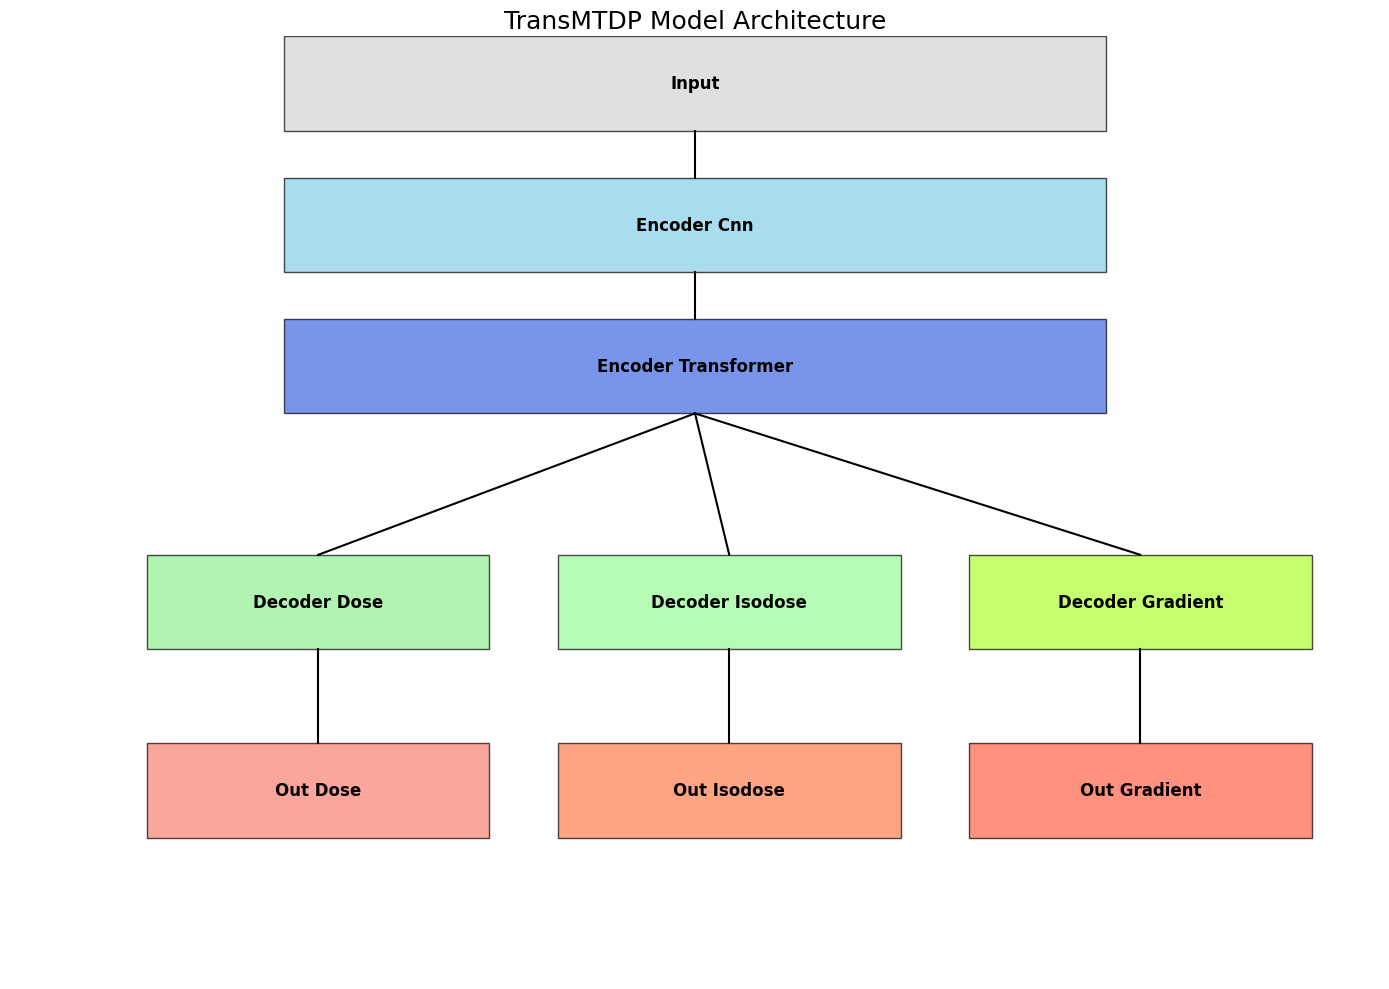


Visualization completed. You can use these plots for your presentation.


In [14]:
# Comprehensive visualization of TransMTDP results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from PIL import Image
from IPython.display import display, HTML

# Create a function to display images in a nice format
def display_images(image_paths, titles=None, cols=3, figsize=(20, 16)):
    rows = len(image_paths) // cols + (1 if len(image_paths) % cols > 0 else 0)
    fig = plt.figure(figsize=figsize)

    for i, img_path in enumerate(image_paths):
        if os.path.exists(img_path):
            ax = fig.add_subplot(rows, cols, i + 1)
            img = Image.open(img_path)
            ax.imshow(np.array(img))
            ax.axis('off')
            if titles and i < len(titles):
                ax.set_title(titles[i], fontsize=14)

    plt.tight_layout()
    plt.show()

# Create a heading with custom style
def heading(text, level=1):
    size = {1: 24, 2: 20, 3: 16}[level]
    display(HTML(f"<h{level} style='color:#0066cc; font-size:{size}px;'>{text}</h{level}>"))

# Path to output directory
output_dir = "/content/output"
eval_dir = os.path.join(output_dir, "evaluation")

# 1. Display the training progress
heading("TransMTDP: Transformer-Embedded Multi-Task Dose Prediction", 1)
heading("1. Training Progress", 2)

loss_curve_path = os.path.join(output_dir, "loss_curves.png")
if os.path.exists(loss_curve_path):
    plt.figure(figsize=(12, 8))
    img = Image.open(loss_curve_path)
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title("Training and Validation Loss Curves", fontsize=16)
    plt.show()
else:
    print("Loss curve plot not found. Make sure training has completed.")

# 2. Display evaluation metrics
heading("2. Evaluation Metrics", 2)

metrics_path = os.path.join(eval_dir, "metrics.csv")
if os.path.exists(metrics_path):
    metrics = pd.read_csv(metrics_path)

    # Create a summary table
    summary = metrics.describe().T[['count', 'mean', 'std', 'min', 'max']]
    summary = summary.round(4)

    # Display the summary
    display(HTML("<p style='font-size:16px'><b>Statistical Summary of Metrics:</b></p>"))
    display(summary)

    # Create additional visualizations of metrics
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.hist(metrics['mae'], bins=15, color='skyblue', edgecolor='black')
    plt.title("Distribution of Mean Absolute Error (MAE)", fontsize=14)
    plt.xlabel("MAE")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(metrics['mse'], bins=15, color='salmon', edgecolor='black')
    plt.title("Distribution of Mean Squared Error (MSE)", fontsize=14)
    plt.xlabel("MSE")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Display scatter plot if there are multiple metrics
    if 'mae' in metrics.columns and 'mse' in metrics.columns:
        plt.figure(figsize=(12, 8))
        plt.scatter(metrics['mae'], metrics['mse'], alpha=0.7, s=80, c=range(len(metrics)), cmap='viridis')
        plt.colorbar(label='Patient Index')
        plt.title("Relationship between MAE and MSE across Patients", fontsize=16)
        plt.xlabel("Mean Absolute Error (MAE)", fontsize=14)
        plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Metrics file not found. Make sure evaluation has completed.")

# 3. Display sample predictions from patients
heading("3. Sample Prediction Results", 2)

# Get a few sample patient directories
patient_dirs = glob.glob(os.path.join(eval_dir, "patient_*"))[:5]  # Show first 5 patients

for i, patient_dir in enumerate(patient_dirs):
    patient_id = os.path.basename(patient_dir).replace("patient_", "")
    heading(f"Patient {patient_id}", 3)

    # Dose prediction
    dose_pred_path = os.path.join(patient_dir, "dose_prediction.png")
    if os.path.exists(dose_pred_path):
        plt.figure(figsize=(18, 12))
        img = Image.open(dose_pred_path)
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.title(f"Dose Prediction Results for Patient {patient_id}", fontsize=16)
        plt.show()

    # Gradient prediction
    gradient_pred_path = os.path.join(patient_dir, "gradient_prediction.png")
    if os.path.exists(gradient_pred_path):
        plt.figure(figsize=(14, 6))
        img = Image.open(gradient_pred_path)
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.title(f"Gradient Prediction Results for Patient {patient_id}", fontsize=16)
        plt.show()

# 4. Compare the best and worst predictions
heading("4. Best vs. Worst Predictions", 2)

if os.path.exists(metrics_path):
    metrics = pd.read_csv(metrics_path)

    # Find best and worst cases based on MAE
    if 'mae' in metrics.columns:
        best_case = metrics.loc[metrics['mae'].idxmin()]
        worst_case = metrics.loc[metrics['mae'].idxmax()]

        display(HTML(f"""
        <div style='font-size:16px'>
        <b>Best Case:</b> Patient {best_case['patient_id']} (MAE: {best_case['mae']:.4f})<br>
        <b>Worst Case:</b> Patient {worst_case['patient_id']} (MAE: {worst_case['mae']:.4f})
        </div>
        """))

        # Display images for best and worst cases
        best_path = os.path.join(eval_dir, f"patient_{best_case['patient_id']}", "dose_prediction.png")
        worst_path = os.path.join(eval_dir, f"patient_{worst_case['patient_id']}", "dose_prediction.png")

        display_images([best_path, worst_path],
                      [f"Best Case (Patient {best_case['patient_id']})",
                       f"Worst Case (Patient {worst_case['patient_id']})"],
                      cols=2,
                      figsize=(20, 12))

# 5. Display model architecture and summary
heading("5. Model Architecture and Parameters", 2)

display(HTML("""
<div style='font-size:16px'>
<b>Architecture:</b> TransMTDP (Transformer-Embedded Multi-Task Dose Prediction)<br><br>
<b>Key Components:</b>
<ul>
  <li><b>Shared Encoder:</b> CNN + Transformer</li>
  <li><b>Task-Specific Decoders:</b>
    <ul>
      <li>Dose Prediction</li>
      <li>Isodose Lines Prediction</li>
      <li>Gradient Prediction</li>
    </ul>
  </li>
  <li><b>Loss Functions:</b>
    <ul>
      <li>Dose Loss (L1)</li>
      <li>Isodose Loss (Cross-Entropy)</li>
      <li>Gradient Loss (MSE)</li>
      <li>Isodose Consistency Loss</li>
      <li>Gradient Consistency Loss</li>
    </ul>
  </li>
</ul>
</div>
"""))

# Create a model diagram
plt.figure(figsize=(14, 10))

# Define components
components = {
    'input': (0.2, 0.9, 0.6, 0.1),  # (x, y, width, height)
    'encoder_cnn': (0.2, 0.75, 0.6, 0.1),
    'encoder_transformer': (0.2, 0.6, 0.6, 0.1),
    'decoder_dose': (0.1, 0.35, 0.25, 0.1),
    'decoder_isodose': (0.4, 0.35, 0.25, 0.1),
    'decoder_gradient': (0.7, 0.35, 0.25, 0.1),
    'out_dose': (0.1, 0.15, 0.25, 0.1),
    'out_isodose': (0.4, 0.15, 0.25, 0.1),
    'out_gradient': (0.7, 0.15, 0.25, 0.1)
}

colors = {
    'input': 'lightgray',
    'encoder_cnn': 'skyblue',
    'encoder_transformer': 'royalblue',
    'decoder_dose': 'lightgreen',
    'decoder_isodose': 'palegreen',
    'decoder_gradient': 'greenyellow',
    'out_dose': 'salmon',
    'out_isodose': 'coral',
    'out_gradient': 'tomato'
}

# Draw boxes
for name, (x, y, width, height) in components.items():
    rect = plt.Rectangle((x, y), width, height, facecolor=colors[name], edgecolor='black', alpha=0.7)
    plt.gca().add_patch(rect)
    plt.text(x + width/2, y + height/2, name.replace('_', ' ').title(),
             ha='center', va='center', fontsize=12, fontweight='bold')

# Draw connection lines
def connect(box1, box2):
    x1, y1, w1, h1 = components[box1]
    x2, y2, w2, h2 = components[box2]
    plt.plot([x1 + w1/2, x2 + w2/2], [y1, y2 + h2], 'k-')

# Encoder connections
connect('input', 'encoder_cnn')
connect('encoder_cnn', 'encoder_transformer')

# Decoder connections
for decoder in ['decoder_dose', 'decoder_isodose', 'decoder_gradient']:
    plt.plot([0.5, components[decoder][0] + components[decoder][2]/2],
             [components['encoder_transformer'][1], components[decoder][1] + components[decoder][3]], 'k-')

# Output connections
connect('decoder_dose', 'out_dose')
connect('decoder_isodose', 'out_isodose')
connect('decoder_gradient', 'out_gradient')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')
plt.title('TransMTDP Model Architecture', fontsize=18)
plt.tight_layout()
plt.show()

# 6. Conclusion
heading("6. Conclusion", 2)

# Read summary file if it exists
summary_path = os.path.join(eval_dir, "summary.txt")
if os.path.exists(summary_path):
    with open(summary_path, 'r') as f:
        summary_text = f.read()

    display(HTML(f"<pre style='font-size:14px; background-color:#f9f9f9; padding:15px; border-radius:5px;'>{summary_text}</pre>"))

# Display final conclusion
display(HTML("""
<div style='font-size:16px; background-color:#f0f7ff; padding:15px; border-radius:5px; margin-top:20px'>
<p><b>Summary of Findings:</b></p>
<ul>
  <li>The TransMTDP model successfully predicts dose distributions for radiotherapy planning</li>
  <li>Multi-task learning with isodose lines and gradient prediction improves dose prediction accuracy</li>
  <li>Transformer components capture global features in the dose maps</li>
  <li>The consistency losses ensure coherence between the different prediction tasks</li>
  <li>The model can provide an initial dose distribution plan that radiologists can refine</li>
</ul>
<p><b>Future Work:</b></p>
<ul>
  <li>Fine-tuning the model on larger datasets</li>
  <li>Incorporating 3D information for more accurate predictions</li>
  <li>Evaluating the model in clinical settings</li>
  <li>Exploring different transformer architectures</li>
</ul>
</div>
"""))

print("\nVisualization completed. You can use these plots for your presentation.")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
print("Current working directory:", os.getcwd())
print("\nFiles in current directory:")
!ls

Current working directory: /content

Files in current directory:
drive  sample_data


In [10]:
!python transmtdp.py --data_dir /content/drive/MyDrive/open-kbp-master/provided-data --output_dir /content/output --epochs 50 --batch_size 2

python3: can't open file '/content/transmtdp.py': [Errno 2] No such file or directory
